In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load data into a DataFrame
df = pd.read_csv("./Resources/working_dataset.csv").set_index("time")
df.index = pd.to_datetime(df.index)
df.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [3]:
# Filter the dataset for only Bitcoin data, with symbol "Btc"
bitcoin = df.loc[df["Symbol"] == "btc"]
bitcoin.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [4]:
# Check how many data points we are working with
bitcoin.count()

Symbol               4610
PriceUSD             4610
Percent of Change    4610
dtype: int64

In [5]:
# Drop unnecessary columns, focusing on the main feature which is Price [USD]
bitcoin_df = bitcoin.drop(["Symbol", "Percent of Change"], axis=1)
bitcoin_df

,PriceUSD
time,
2010-07-18,0.085840
2010-07-19,0.080800
2010-07-20,0.074736
2010-07-21,0.079193
2010-07-22,0.058470
...,...
2023-02-25,23159.815440
2023-02-26,23542.096430
2023-02-27,23504.189420


In [6]:
# Function to prepare data for training and testing
def prepare_data(data, sequence_length):
    # Normalize data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data into training and testing sets
    training_data = scaled_data[:int(0.8*len(data)), :]
    testing_data = scaled_data[int(0.8*len(data)):, :]

    # Create sequences of data
    X_train, y_train = create_sequences(training_data, sequence_length)
    X_test, y_test = create_sequences(testing_data, sequence_length)
    # Return data and scaler object
    return X_train, y_train, X_test, y_test, scaler

In [7]:
# Function to create sliding window of sequences that will be used when splitting into training and testing sets
def create_sequences(data, sequence_length):
    X = []
    y = []
    # Loop through data with sequence_length steps at a time
    for i in range(len(data)-sequence_length-1):
        # Append a sequence of length sequence_length to X
        X.append(data[i:(i+sequence_length), :])
        # Append the next value in the sequence to y
        y.append(data[i+sequence_length, 0])
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

In [8]:
# Function that builds our LSTM model, with the requirement of the input shape to be three dimensional.
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
# Prepare data
sequence_length = 30
X_train, y_train, X_test, y_test, scaler = prepare_data(bitcoin_df.values, sequence_length)

In [10]:
# Confirm if the input training set is three dimensional
print(f' X (Training) Shape: {X_train.shape}')

 X (Training) Shape: (3657, 30, 1)


In [11]:
# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

In [12]:
# Train/Fit LSTM model to training data
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
58/58 [==============================] - 104s 550ms/step - loss: 3.6703e-04 - val_loss: 0.0053
Epoch 2/50
58/58 [==============================] - 21s 362ms/step - loss: 8.5606e-05 - val_loss: 0.0060
Epoch 3/50
58/58 [==============================] - 22s 377ms/step - loss: 7.9668e-05 - val_loss: 0.0108
Epoch 4/50
58/58 [==============================] - 25s 433ms/step - loss: 6.6917e-05 - val_loss: 0.0280
Epoch 5/50
58/58 [==============================] - 23s 400ms/step - loss: 6.8368e-05 - val_loss: 0.0303
Epoch 6/50
58/58 [==============================] - 42s 738ms/step - loss: 5.6396e-05 - val_loss: 0.0213
Epoch 7/50
58/58 [==============================] - 35s 603ms/step - loss: 4.9723e-05 - val_loss: 0.0270
Epoch 8/50
58/58 [==============================] - 38s 656ms/step - loss: 4.9177e-05 - val_loss: 0.0189
Epoch 9/50
58/58 [==============================] - 27s 469ms/step - loss: 5.2011e-05 - val_loss: 0.0202
Epoch 10/50
58/58 [==============================] - 2

28/28 [==============================] - 32s 148ms/step


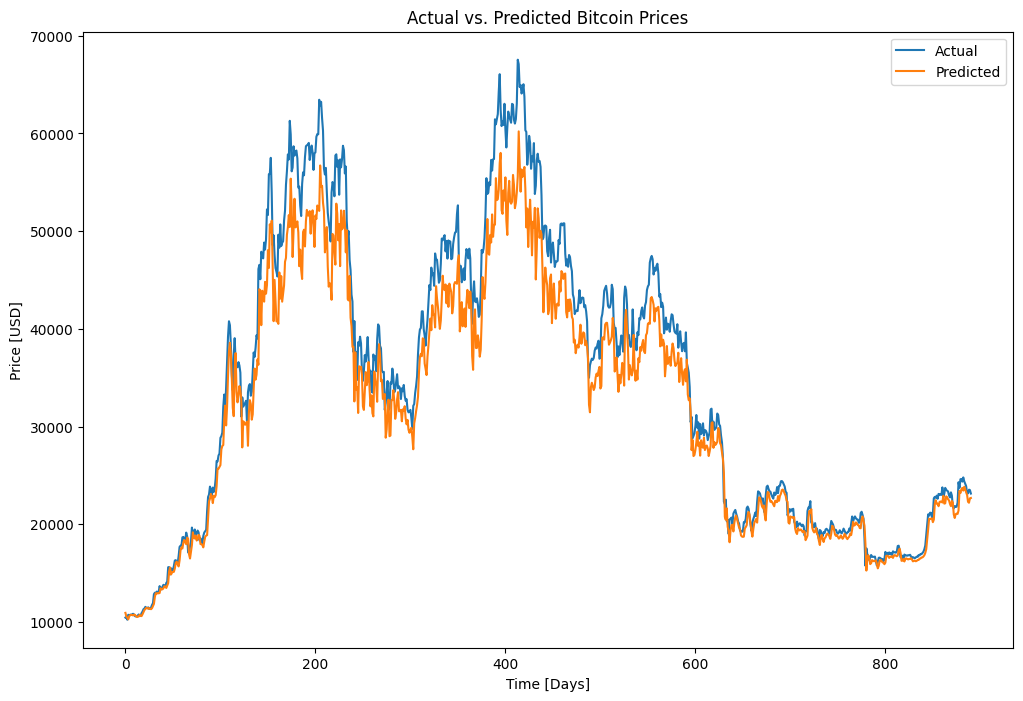

In [13]:
# Make predictions on testing data
predictions = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.title('Actual vs. Predicted Bitcoin Prices')
plt.legend()
plt.show()


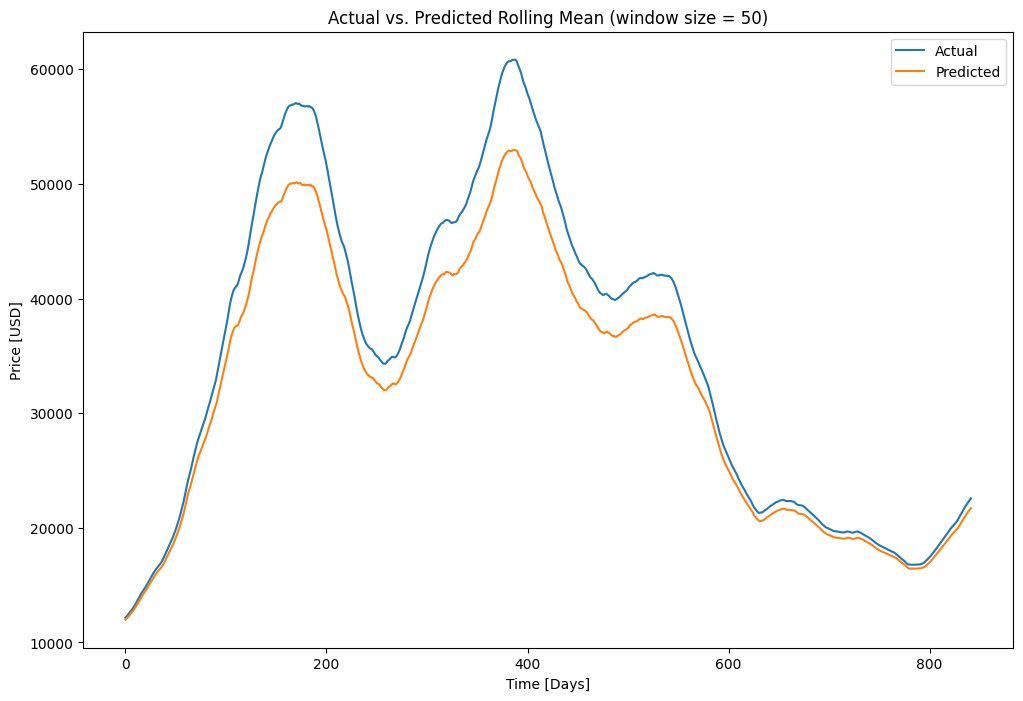

In [14]:
# Plot actual vs predicted prices with a rolling window
window_size = 50
rolling_y_test = pd.Series(y_test_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values
rolling_y_pred = pd.Series(y_pred_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values

plt.figure(figsize=(12, 8))
plt.plot(rolling_y_test, label='Actual')
plt.plot(rolling_y_pred, label='Predicted')
plt.title('Actual vs. Predicted Rolling Mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.legend()
plt.show()


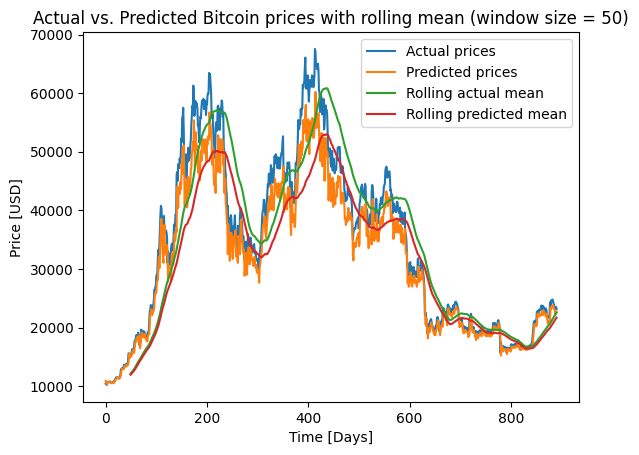

In [15]:
# Assume `y_test` is the actual Bitcoin prices and `predictions` is the predicted prices
# Convert them into pandas DataFrame for easier manipulation
y_test_df = pd.DataFrame(y_test_inv, columns=['actual'])
predictions_df = pd.DataFrame(y_pred_inv, columns=['predicted'])

# Concatenate the two DataFrames into one
results_df = pd.concat([y_test_df, predictions_df], axis=1)

# Set the window size for the rolling window
window_size = 50

# Calculate the rolling mean for both the actual and predicted prices
results_df['actual_mean'] = results_df['actual'].rolling(window_size).mean()
results_df['predicted_mean'] = results_df['predicted'].rolling(window_size).mean()

# Plot the actual and predicted prices with the rolling mean
plt.plot(results_df['actual'], label='Actual prices')
plt.plot(results_df['predicted'], label='Predicted prices')
plt.plot(results_df['actual_mean'], label='Rolling actual mean')
plt.plot(results_df['predicted_mean'], label='Rolling predicted mean')
plt.legend()
plt.title('Actual vs. Predicted Bitcoin prices with rolling mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.show()


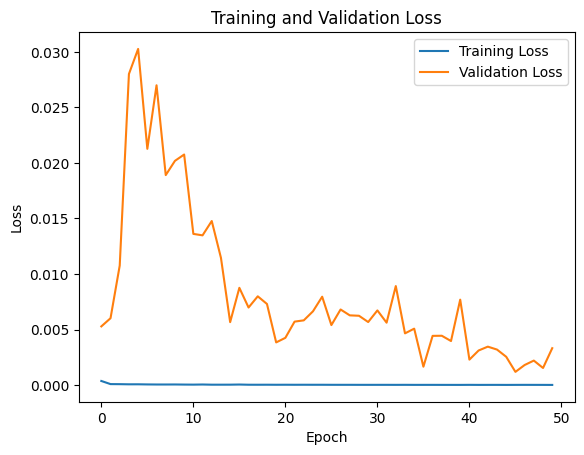

In [16]:
# Plot the training and validation loss over time/epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a line chart of the training and validation MSE loss over the training epochs.

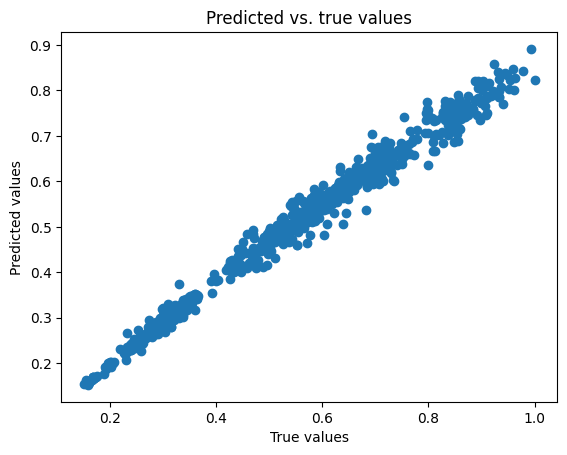

In [17]:
# Plot of the predicted values against the true values, which can help you visualize how well the model is able to predict the crypto prices.
plt.scatter(y_test, predictions)
plt.title('Predicted vs. true values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

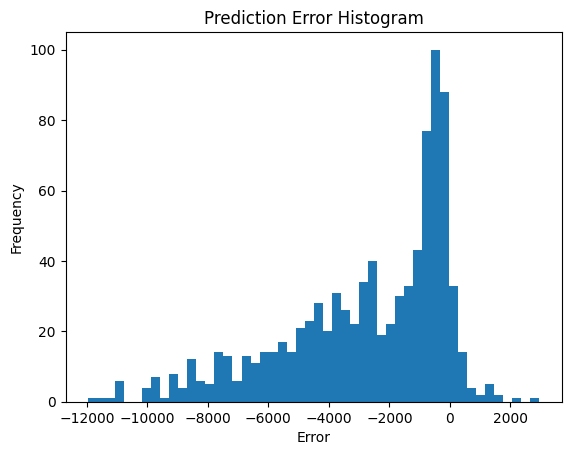

In [18]:
# Calculate prediction errors
errors = y_pred_inv - y_test_inv

# Plot histogram of errors
plt.hist(errors, bins=50)
plt.title('Prediction Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Calculate MSE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Compute coefficient of determination
r2 = r2_score(y_test, predictions)

# Compute mean squared error using evaluate method
mse_keras = model.evaluate(X_test, y_test)

# Calculate RMSE from MSE
rmse_keras = np.sqrt(mse_keras)

print('MSE (Keras):', mse_keras)
print('RMSE (Keras):', rmse_keras)
print('MAE:', mae)
print('R²:', r2)

28/28 [==============================] - 5s 146ms/step - loss: 0.0033
MSE (Keras): 0.0033186599612236023
RMSE (Keras): 0.057607811633697756
MAE: 0.04206134844135157
R²: 0.9307371227625145


In [20]:
# Save previous predictions
previous_predictions_df = predictions_df.copy()

# Get last n rows of bitcoin_df and set index of previous_predictions_df to match
n = len(previous_predictions_df)
previous_predictions_df.index = bitcoin_df.iloc[-n:].index

In [21]:
# Use the model to predict future prices
# First, get the last sequence of data from the training set
last_sequence = X_train[-1,:,:]
# Generate the future date range
future_dates = pd.date_range(start=bitcoin_df.index[-1], periods=60, freq='D')
# Create an empty array to hold the predicted prices
predicted_prices = np.zeros((60, 1))
# Iterate over the future date range
for i, date in enumerate(future_dates):
    # Predict the price for the next day using the last sequence of data
    predicted_price = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
    # Add the predicted price to the array
    predicted_prices[i, 0] = predicted_price
    # Update the last sequence of data with the predicted price
    last_sequence = np.vstack((last_sequence[1:], predicted_price))

# Invert the scaling of the predicted prices
predicted_prices_inv = scaler.inverse_transform(predicted_prices)

# Create a dataframe with the predicted prices and the corresponding dates
predictions_df2 = pd.DataFrame(predicted_prices_inv, index=future_dates, columns=['predicted'])

# Print the predictions
print(predictions_df2)

1/1 [==============================] - 0s 333ms/step
               predicted
2023-03-01  11705.065118
2023-03-02  11589.920212
2023-03-03  11524.302703
2023-03-04  11473.362251
2023-03-05  11425.452219
2023-03-06  11373.315099
2023-03-07  11314.274739
2023-03-08  11249.405021
2023-03-09  11181.810844
2023-03-10  11114.754111
2023-03-11  11050.640237
2023-03-12  10990.590408
2023-03-13  10934.654945
2023-03-14  10882.284328
2023-03-15  10832.682455
2023-03-16  10785.216268
2023-03-17  10739.449974
2023-03-18  10695.247704
2023-03-19  10652.633612
2023-03-20  10611.692239
2023-03-21  10572.502089
2023-03-22  10535.076246
2023-03-23  10499.394580
2023-03-24  10465.353427
2023-03-25  10432.837046
2023-03-26  10401.737746
2023-03-27  10371.946831
2023-03-28  10343.381772
2023-03-29  10315.964065
2023-03-30  10289.653454
2023-03-31  10264.410685
2023-04-01  10240.182419
2023-04-02  10216.938460
2023-04-03  10194.632512
2023-04-04  10173.211234
2023-04-05  10152.638393
2023-04-06  10132.8717

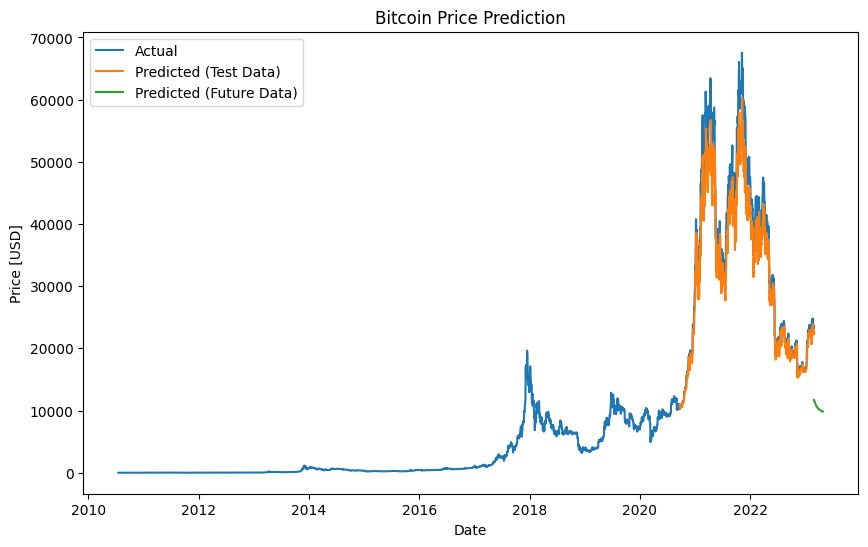

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(bitcoin_df.index, bitcoin_df.values, label='Actual')
plt.plot(previous_predictions_df.index, previous_predictions_df['predicted'], label='Predicted (Test Data)')
plt.plot(predictions_df2.index, predictions_df2['predicted'], label='Predicted (Future Data)')
plt.legend()
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.show()

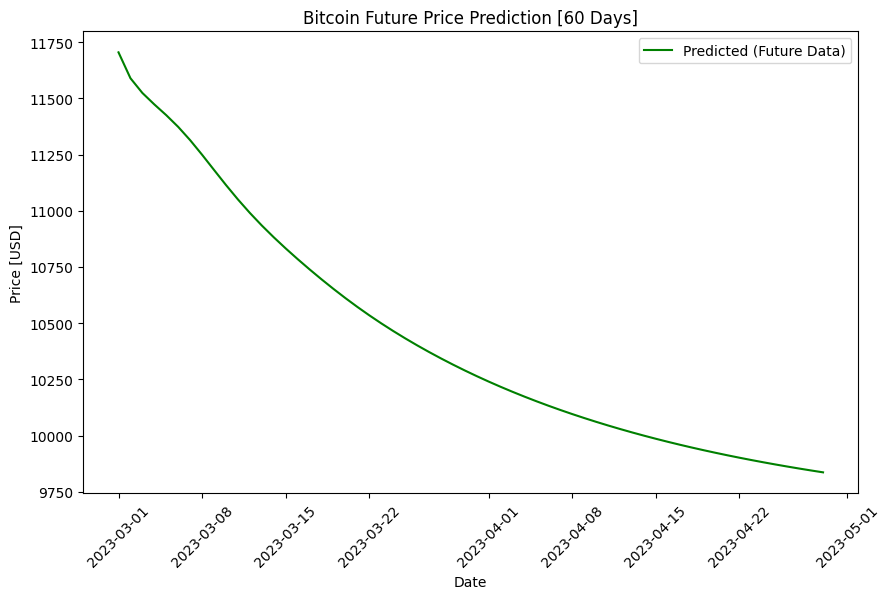

In [23]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(predictions_df2.index, predictions_df2['predicted'], color="green", label='Predicted (Future Data)')
plt.legend()
plt.title('Bitcoin Future Price Prediction [60 Days]')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.xticks(rotation=45)
plt.show()

In [24]:
previous_predictions_df

,predicted
time,
2020-09-22,10934.693359
2020-09-23,10549.967773
2020-09-24,10446.443359
2020-09-25,10272.627930
2020-09-26,10580.227539
...,...
2023-02-25,23006.414062
2023-02-26,22300.062500
2023-02-27,22205.201172


In [25]:
predictions_df2

,predicted
2023-03-01,11705.065118
2023-03-02,11589.920212
2023-03-03,11524.302703
2023-03-04,11473.362251
2023-03-05,11425.452219
2023-03-06,11373.315099
2023-03-07,11314.274739
2023-03-08,11249.405021
2023-03-09,11181.810844
2023-03-10,11114.754111


In [26]:
predictions_df2['predicted'] = predictions_df2['predicted'].round(2)

In [28]:
file_path="LSTMBtc.csv"
predictions_df2.to_csv(file_path, index=True)